In [ ]:
#!pip install geopy
#!pip install geocoder

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
##client_ID
##client_secret
##version
#CLIENT_ID = 'XVEGD2FCXA0AUIZN0LEXEWDPQUSMMHU1DHQLYK1ZTVSKFLCA' # your Foursquare ID
#CLIENT_SECRET = 'APT3YHYX435I5ETREJSKLYZ51GYXOYPGABRN3UMHHMESLOOS' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version
#
# client details from additional account
CLIENT_ID = 'KW0PYRNOOMLGG21QRWRCIYD44NL4NUZOMRUDZ3TLL3PQLIWP'
CLIENT_SECRET = 'LS3OJBEQW4I0EEQNYVU1VQNO2FUGNCMWVSVQXQYF5TUVVXMC'
VERSION = '20180605' # Foursquare API version

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
#    CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
#    CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
#    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [5]:
def get_venue_details(venue_id):
        
#    CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
#    CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
#    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [7]:
# get new york data
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

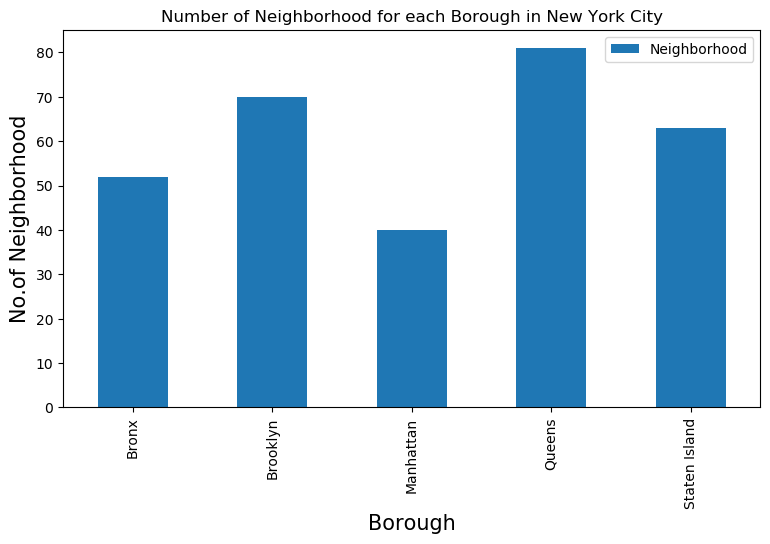

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Korean resturants for each Neighborhood

In [11]:
# prepare neighborhood list that contains korean resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
korean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    korean_resturants=venues[venues['Category']=='Korean Restaurant']   
    print('(',count,'/',len(new_york_data),')','Korean Resturants in '+Neighborhood+', '+Borough+':'+str(len(korean_resturants)))
    for resturant_detail in korean_resturants.values.tolist():
        id, name , category=resturant_detail
        korean_rest_ny = korean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Korean Resturants in Wakefield, Bronx:0
( 2 / 306 ) Korean Resturants in Co-op City, Bronx:0
( 3 / 306 ) Korean Resturants in Eastchester, Bronx:0
( 4 / 306 ) Korean Resturants in Fieldston, Bronx:0
( 5 / 306 ) Korean Resturants in Riverdale, Bronx:0
( 6 / 306 ) Korean Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Korean Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Korean Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Korean Resturants in Norwood, Bronx:0
( 10 / 306 ) Korean Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Korean Resturants in Baychester, Bronx:0
( 12 / 306 ) Korean Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Korean Resturants in City Island, Bronx:0
( 14 / 306 ) Korean Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Korean Resturants in University Heights, Bronx:0
( 16 / 306 ) Korean Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Korean Resturants in Fordham, Bronx:0
( 18 / 306 ) Korean Resturants in East Tremont, Bronx:0
( 19 / 306 ) Kor

( 143 / 306 ) Korean Resturants in Maspeth, Queens:0
( 144 / 306 ) Korean Resturants in Ridgewood, Queens:0
( 145 / 306 ) Korean Resturants in Glendale, Queens:0
( 146 / 306 ) Korean Resturants in Rego Park, Queens:0
( 147 / 306 ) Korean Resturants in Woodhaven, Queens:0
( 148 / 306 ) Korean Resturants in Ozone Park, Queens:0
( 149 / 306 ) Korean Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Korean Resturants in College Point, Queens:1
( 151 / 306 ) Korean Resturants in Whitestone, Queens:0
( 152 / 306 ) Korean Resturants in Bayside, Queens:2
( 153 / 306 ) Korean Resturants in Auburndale, Queens:14
( 154 / 306 ) Korean Resturants in Little Neck, Queens:4
( 155 / 306 ) Korean Resturants in Douglaston, Queens:4
( 156 / 306 ) Korean Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Korean Resturants in Bellerose, Queens:0
( 158 / 306 ) Korean Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Korean Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Korean Resturants in Briar

( 280 / 306 ) Korean Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Korean Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Korean Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Korean Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Korean Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Korean Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Korean Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Korean Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Korean Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Korean Resturants in Roxbury, Queens:0
( 290 / 306 ) Korean Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Korean Resturants in Middle Village, Queens:0
( 292 / 306 ) Korean Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Korean Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Korean Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Korean Resturants in Malba, Queens:1
( 296 / 306 ) Korean Re

Now that we have got all the korean resturants in new york city , we will analyze it

In [12]:
korean_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bensonhurst,57049cb4498efcebf6578c1b,Cafe Lily
1,Brooklyn,Brighton Beach,4c9d5c0303133704a96f5ed5,Cafe At Your Mother-in-Law
2,Brooklyn,Prospect Heights,4fa162e0e4b0badc81404a51,Kimchi Grill
3,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory
4,Brooklyn,Park Slope,5bba42ff7dc9e1002cd1a1df,Haenyeo


In [13]:
korean_rest_ny.shape

(115, 4)

##### We got 115 Korean Resturants across New York City

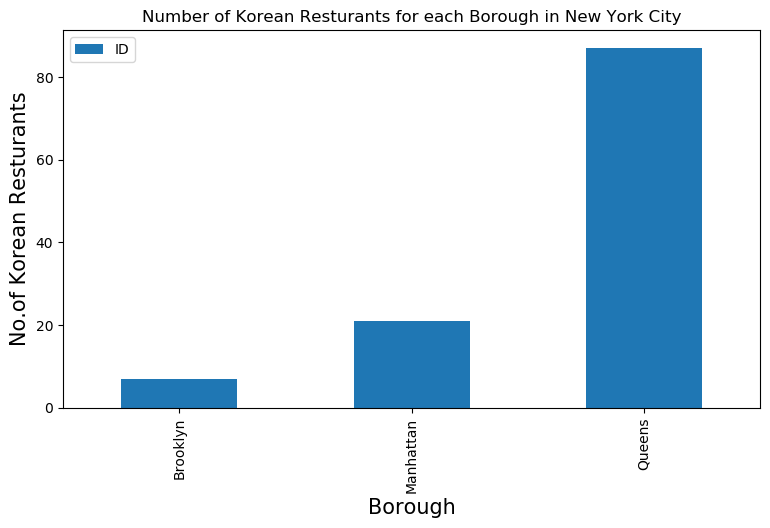

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Korean Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Korean Resturants', fontsize=15)
#giving a bar plot
korean_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of korean resturants

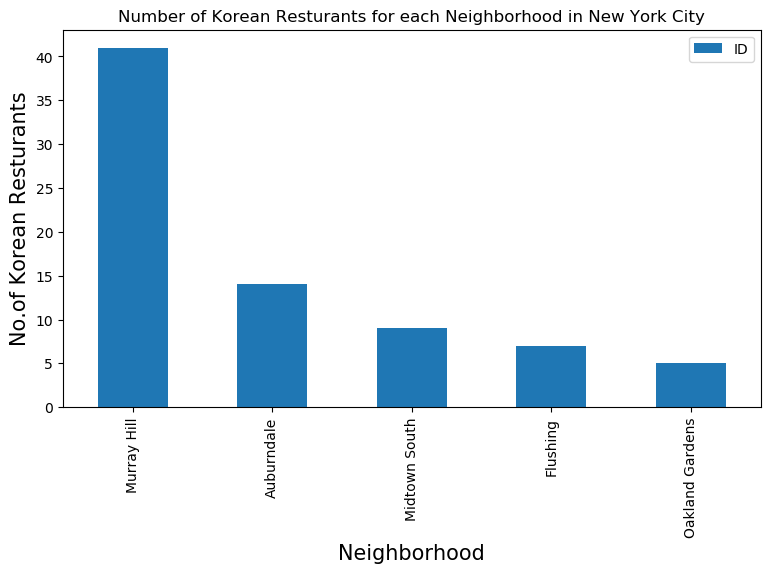

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Korean Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Korean Resturants', fontsize=15)
#giving a bar plot
korean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:
korean_rest_ny[korean_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
7,Manhattan,Murray Hill,41e46880f964a520d81e1fe3,Don's Bogam Korean BBQ & Wine
8,Manhattan,Murray Hill,547d03e3498eb32c879589da,Baekjeong NYC (Kang Ho Dong Baekjeong)
9,Manhattan,Murray Hill,560b19b1498ee5e226c151f9,Her Name is Han
10,Manhattan,Murray Hill,517563f9498e0a4859d08fe4,BCD Tofu House
11,Manhattan,Murray Hill,4efe024000396c3b17c070e1,Take 31
59,Queens,Murray Hill,4b830e44f964a520ebf430e3,Hahm Ji Bach - 함지박
60,Queens,Murray Hill,4b8f0931f964a520d04533e3,Mapo BBQ
61,Queens,Murray Hill,49e10e0bf964a52089611fe3,Mad For Chicken
62,Queens,Murray Hill,4baeabe6f964a52037cd3be3,Kum Sung Chik Naengmyun
63,Queens,Murray Hill,56db53cc498eed9b68621019,SGD Tofu House


Murray Hill in Queens has the highest number of Korean Resturants with a total count of 41.

Now we will get the ranking of each resturant for further analysis.

In [ ]:
#CLIENT_ID = 'KW0PYRNOOMLGG21QRWRCIYD44NL4NUZOMRUDZ3TLL3PQLIWP'
#CLIENT_SECRET = 'LS3OJBEQW4I0EEQNYVU1VQNO2FUGNCMWVSVQXQYF5TUVVXMC'
#VERSION = '20180605' # Foursquare API version

In [17]:
# prepare neighborhood list that contains korean resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
korean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in korean_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(korean_rest_ny),')','processed')
    korean_rest_stats_ny = korean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  57049cb4498efcebf6578c1b  Cafe Lily      7     6.5     7
( 1 / 115 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4c9d5c0303133704a96f5ed5  Cafe At Your Mother-in-Law     28     7.6    28
( 2 / 115 ) processed
                         ID          Name  Likes  Rating  Tips
0  4fa162e0e4b0badc81404a51  Kimchi Grill    289     8.4   108
( 3 / 115 ) processed
                         ID    Name  Likes  Rating  Tips
0  52bf3053498e754b09a440b5  Dotory    138     8.5    44
( 4 / 115 ) processed
                         ID     Name  Likes  Rating  Tips
0  5bba42ff7dc9e1002cd1a1df  Haenyeo     38     8.1     9
( 5 / 115 ) processed
                         ID        Name  Likes  Rating  Tips
0  5ae4e10ffe3740002d8a897e  Slow Loris     12     8.1     5
( 6 / 115 ) processed
                         ID    Name  Likes  Rating  Tips
0  52bf3053498e754b09a440b5  Dotory    138     8.5    44
( 

                         ID             Name  Likes  Rating  Tips
0  58efc04912c8f0495ec6865c  Chilsung Garden     15     7.7     1
( 56 / 115 ) processed
                         ID          Name  Likes  Rating  Tips
0  526c1acf11d288dc8354b7b9  Rolly Kimbab     26     7.2     9
( 57 / 115 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b9d4ce7f964a5209ba136e3
( 58 / 115 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c5ed60d857ca5936497d0cb
( 59 / 115 ) processed
                         ID                Name  Likes  Rating  Tips
0  4b830e44f964a520ebf430e3  Hahm Ji Bach - 함지박    212     8.8    81
( 60 / 115 ) processed
                         ID      Name  Likes  Rating  Tips
0  4b8f0931f964a520d04533e3  Mapo BBQ     79     8.6    32
( 61 / 115 ) processed
                         ID             Name  Likes  Rating  Tips
0  49e10e0bf964a52089611fe3  Mad For Chicken  

                         ID     Name  Likes  Rating  Tips
0  4efe024000396c3b17c070e1  Take 31    272     8.7    57
( 108 / 115 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4dc9923322717adb0377893e
( 109 / 115 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4dc9923322717adb0377893e
( 110 / 115 ) processed
                         ID              Name  Likes  Rating  Tips
0  578bec6c498e3150fc369f3b  Thursday Kitchen    269     8.9    70
( 111 / 115 ) processed
                         ID      Name  Likes  Rating  Tips
0  4c0c2765a1b32d7f49279cf0  Sik Gaek     77     8.4    42
( 112 / 115 ) processed
                         ID              Name  Likes  Rating  Tips
0  57ab54da498e7d61e0c1fe0e  Pelicana Chicken     24     7.6     7
( 113 / 115 ) processed
                         ID  Name  Likes  Rating  Tips
0  5630104d498e08f2c7217877  Doma     17     7.5     4
( 114 / 

In [18]:
korean_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bensonhurst,57049cb4498efcebf6578c1b,Cafe Lily,7,6.5,7
1,Brooklyn,Brighton Beach,4c9d5c0303133704a96f5ed5,Cafe At Your Mother-in-Law,28,7.6,28
2,Brooklyn,Prospect Heights,4fa162e0e4b0badc81404a51,Kimchi Grill,289,8.4,108
3,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory,138,8.5,44
4,Brooklyn,Park Slope,5bba42ff7dc9e1002cd1a1df,Haenyeo,38,8.1,9


In [19]:
korean_rest_stats_ny.shape

(115, 7)

In [20]:
korean_rest_ny.shape

(115, 4)

So we got data for all resturants. Now lets save this data to a csv sheet, in case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [21]:
korean_rest_stats_ny.to_csv('korean_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [22]:
korean_rest_stats_ny_csv=pd.read_csv('korean_rest_stats_ny.csv')

In [23]:
korean_rest_stats_ny_csv.shape

(115, 7)

In [24]:
korean_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bensonhurst,57049cb4498efcebf6578c1b,Cafe Lily,7,6.5,7
1,Brooklyn,Brighton Beach,4c9d5c0303133704a96f5ed5,Cafe At Your Mother-in-Law,28,7.6,28
2,Brooklyn,Prospect Heights,4fa162e0e4b0badc81404a51,Kimchi Grill,289,8.4,108
3,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory,138,8.5,44
4,Brooklyn,Park Slope,5bba42ff7dc9e1002cd1a1df,Haenyeo,38,8.1,9


In [25]:
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 7 columns):
Borough         115 non-null object
Neighborhood    115 non-null object
ID              115 non-null object
Name            115 non-null object
Likes           115 non-null object
Rating          115 non-null float64
Tips            115 non-null object
dtypes: float64(1), object(6)
memory usage: 6.4+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [26]:
korean_rest_stats_ny['Likes']=korean_rest_stats_ny['Likes'].astype('float64')

In [27]:
korean_rest_stats_ny['Tips']=korean_rest_stats_ny['Tips'].astype('float64')

In [28]:
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 7 columns):
Borough         115 non-null object
Neighborhood    115 non-null object
ID              115 non-null object
Name            115 non-null object
Likes           115 non-null float64
Rating          115 non-null float64
Tips            115 non-null float64
dtypes: float64(3), object(4)
memory usage: 6.4+ KB


Now the data types looks correct

In [29]:
# Resturant with maximum Likes
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                 Murray Hill
ID              517563f9498e0a4859d08fe4
Name                      BCD Tofu House
Likes                               1198
Rating                               9.1
Tips                                 198
Name: 10, dtype: object

In [30]:
# Resturant with maximum Rating
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              540f86da498e020149fa7676
Name                          Jongro BBQ
Likes                                798
Rating                               9.3
Tips                                 148
Name: 99, dtype: object

In [31]:
# Resturant with maximum Tips
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                 Murray Hill
ID              517563f9498e0a4859d08fe4
Name                      BCD Tofu House
Likes                               1198
Rating                               9.1
Tips                                 198
Name: 10, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [32]:
ny_neighborhood_stats=korean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [33]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
18,Noho,9.000000
8,East Village,8.950000
16,Midtown South,8.933333
26,Stuyvesant Town,8.900000
29,Tribeca,8.700000
5,Civic Center,8.700000
31,Williamsburg,8.500000
25,South Side,8.500000
22,Prospect Heights,8.400000
12,Jackson Heights,8.100000


Above are the top neighborhoods with top average rating of Korean resturants

In [34]:
ny_borough_stats=korean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [35]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.876190
0,Brooklyn,7.957143
2,Queens,6.065517


Similarly these are the average rating of Korean Resturants for each Borough.

Lets visualize it.

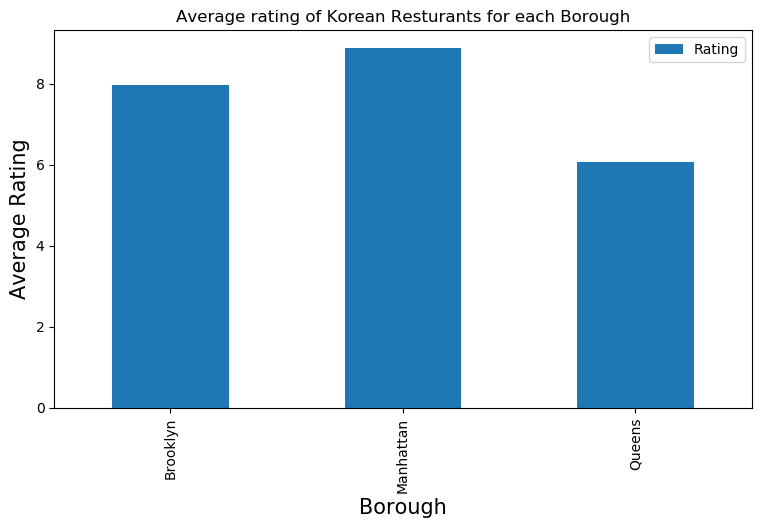

In [36]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Korean Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
korean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [43]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [44]:
ny_neighborhood_stats

,Neighborhood,Average Rating
18,Noho,9.0


We will join this dataset to original new york data to get longitude and latitude

In [45]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [46]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [47]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Noho,40.723259,-73.988434,9.0


Now we will show this data on a map

In [48]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [49]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [50]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [51]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating

In [53]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# borough boundaries downloaded from https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

The saved image can be downloaded at : https://github.com/cvsrao/IBMDataScienceCapstone/blob/master/borough_rating.html

## Conclusion

* Noho (Manhattan), East Village (Manhattan), Midtown South (Manhattan) are some of the best neighborhoods for korean cuisine.
* Queens have potential Korean Resturant Market.
* Staten Island and Bronx do not have any Korean Resturants.
* Manhattan is the best place to stay if you prefer Korean Cuisine.

## Limitations

* The ranking is purely on basis of rating of resturants
* The accuracy of data depends purely depends on the data provided by FourSquare